# Think Bayes

This notebook presents example code and exercise solutions for Think Bayes.

Copyright 2018 Allen B. Downey

MIT License: https://opensource.org/licenses/MIT

In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import classes from thinkbayes2
from thinkbayes2 import Pmf, Suite

import thinkbayes2
import thinkplot

### The Dungeons and Dragons club

Suppose there are 10 people in my *Dungeons and Dragons* club; on any game day, each of them has a 70% chance of showing up.

Each player has one character and each character has 6 attributes, each of which is generated by rolling and adding up 3 6-sided dice.

At the beginning of the game, I ask whose character has the lowest attribute. The wizard says, "My constitution is 5; does anyone have a lower attribute?", and no one does.

The warrior says "My strength is 16; does anyone have a higher attribute?", and no one does.

How many characters are in the party?

### The prior

There are three ways to compute the prior distribution:

* Simulation

* Convolution

* Analytic distribution

First, simulation.  Here's a function that flips a coin with probability `p`:

In [2]:
from random import random

def flip(p):
    return random() < p

We can use it to flip a coin for each member of the club.

In [3]:
flips = [flip(0.7) for i in range(10)]

[False, True, False, True, False, False, True, False, False, True]

And count the number that show up on game day.

In [4]:
sum(flips)

4

Let's encapsulate that in a function that simulates a game day.

In [5]:
def game_day(n, p):
    flips = [flip(p) for i in range(n)]
    return sum(flips)

In [6]:
game_day(10, 0.7)

8

If we run that function many times, we get a sample from the distribution of the number of players.

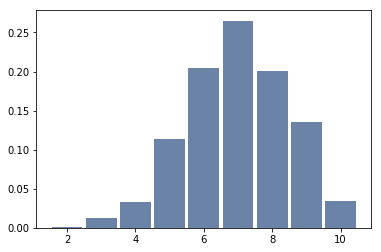

In [7]:
sample = [game_day(10, 0.7) for i in range(1000)]
pmf_sample = Pmf(sample)
thinkplot.Hist(pmf_sample)

The second method is convolution.  Instead of flipping a coin, we can create a `Pmf` object that represents the distribution of outcomes from a single flip.

In [8]:
def coin(p):
    return Pmf({1:p, 0:1-p})

Here's what it looks like.

In [9]:
player = coin(0.7)
player.Print()

0 0.30000000000000004
1 0.7


If we have two players, there are three possible outcomes:

In [10]:
(player + player).Print()

0 0.09000000000000002
1 0.42000000000000004
2 0.48999999999999994


If we have 10 players, we can get the prior distribution like this:

In [11]:
prior = sum([player]*10)
prior.Print()

0 5.9049000000000085e-06
1 0.00013778100000000018
2 0.0014467005000000017
3 0.009001692000000009
4 0.036756909000000025
5 0.10291934520000004
6 0.20012094900000005
7 0.26682793200000005
8 0.2334744405
9 0.12106082099999994
10 0.028247524899999984


Now we can compare the results of simulation and convolution:

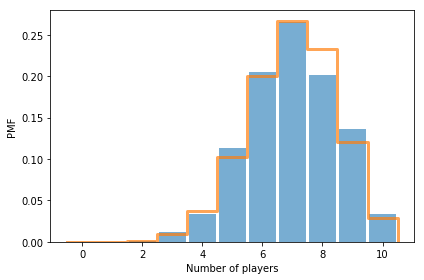

In [12]:
thinkplot.Hist(pmf_sample, color='C0')
thinkplot.Pmf(prior, color='C1')

thinkplot.decorate(xlabel='Number of players',
                   ylabel='PMF')

Finally, we can use an analytic distribution.  The distribution we just computed is the [binomial distribution](https://en.wikipedia.org/wiki/Binomial_distribution), which has the following PMF:

$ PMF(k; n, p) = P(k ~|~ n, p) = {n \choose k}\,p^{k}(1-p)^{n-k}$

We could evalate the right hand side in Python, or use `MakeBinomialPmf`:



In [13]:
help(thinkbayes2.MakeBinomialPmf)

Help on function MakeBinomialPmf in module thinkbayes2.thinkbayes2:

MakeBinomialPmf(n, p)
    Evaluates the binomial PMF.
    
    n: number of trials
    p: probability of success on each trial
    
    Returns: Pmf of number of successes



And we can confirm that the analytic result matches what we computed by convolution.

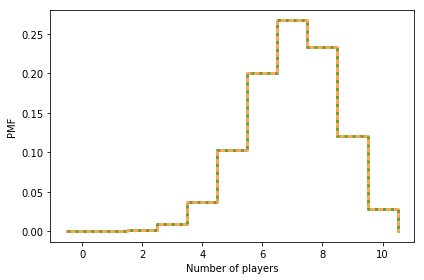

In [14]:
binomial = thinkbayes2.MakeBinomialPmf(10, 0.7)
thinkplot.Pmf(prior, color='C1')
thinkplot.Pmf(binomial, color='C2', linestyle='dotted')

thinkplot.decorate(xlabel='Number of players',
                   ylabel='PMF')

Since two players spoke, we can eliminate the possibility of 0 or 1 players:

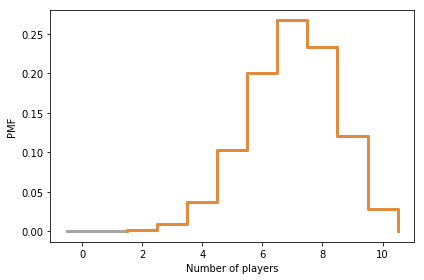

In [15]:
thinkplot.Pmf(prior, color='gray')
del prior[0]
del prior[1]
prior.Normalize()
thinkplot.Pmf(prior, color='C1')

thinkplot.decorate(xlabel='Number of players',
                   ylabel='PMF')

### Likelihood

There are three components of the likelihood function:

* The probability that the highest attribute is 16.

* The probability that the lowest attribute is 5.

* The probability that the lowest and highest attributes are held by different players.

To compute the first component, we have to compute the distribution of the maximum of $6n$ attributes, where $n$ is the number of players.

Here is the distribution for a single die.

In [16]:
d6 = Pmf([1,2,3,4,5,6])
d6.Print()

1 0.16666666666666666
2 0.16666666666666666
3 0.16666666666666666
4 0.16666666666666666
5 0.16666666666666666
6 0.16666666666666666


And here's the distribution for the sum of three dice.

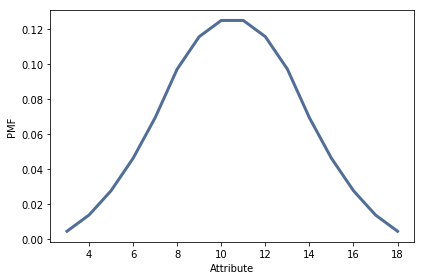

In [17]:
thrice = sum([d6] * 3)
thinkplot.Pdf(thrice)
thinkplot.decorate(xlabel='Attribute',
                   ylabel='PMF')

Here's the CDF for the sum of three dice.

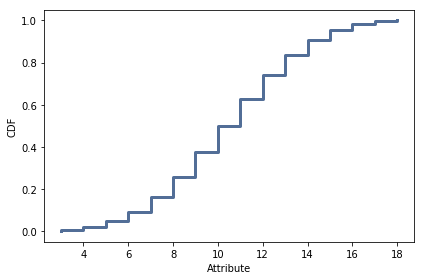

In [18]:
cdf_thrice = thrice.MakeCdf()
thinkplot.Cdf(cdf_thrice)
thinkplot.decorate(xlabel='Attribute',
                   ylabel='CDF')

The `Max` method raises the CDF to a power.  So here's the CDF for the maximum of six attributes.

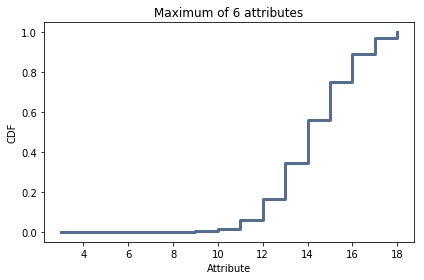

In [19]:
cdf_max_6 = cdf_thrice.Max(6)
thinkplot.Cdf(cdf_max_6)
thinkplot.decorate(xlabel='Attribute',
                   ylabel='CDF',
                   title='Maximum of 6 attributes')

If there are `n` players, there are `6*n` attributes.  Here are the distributions for the maximum attribute of `n` players, for a few values of `n`.

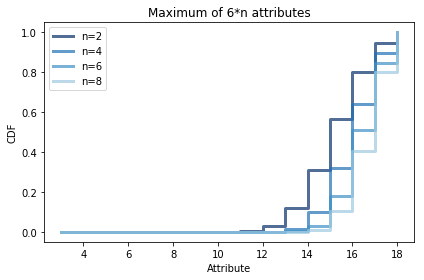

In [20]:
for n in range(2, 10, 2):
    cdf_max = cdf_thrice.Max(n*6)
    thinkplot.Cdf(cdf_max, label='n=%s'%n)

thinkplot.decorate(xlabel='Attribute',
                   ylabel='CDF',
                   title='Maximum of 6*n attributes')

To check that, I'll compute the CDF for 7 players, and estimate it by simulation.

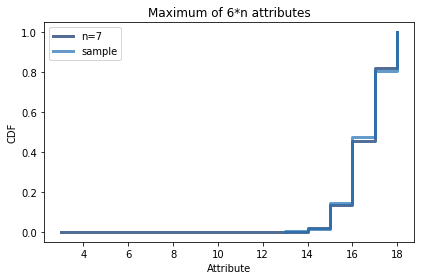

In [21]:
n = 7
cdf = cdf_thrice.Max(n*6)
thinkplot.Cdf(cdf, label='n=%s'%n)

sample_max = [max(cdf_thrice.Sample(42)) for i in range(1000)]
thinkplot.Cdf(thinkbayes2.Cdf(sample_max), label='sample')

thinkplot.decorate(xlabel='Attribute',
                   ylabel='CDF',
                   title='Maximum of 6*n attributes')

Looks good.

Now, to compute the minimum, I have to write my own function, because `Cdf` doesn't provide a `Min` function.

In [22]:
def compute_cdf_min(cdf, k):
    """CDF of the min of k samples from cdf.
    
    cdf: Cdf object
    k: number of samples
    
    returns: new Cdf object
    """
    cdf_min = cdf.Copy()
    cdf_min.ps = 1 - (1 - cdf_min.ps)**k
    return cdf_min

Now we can compute the CDF of the minimum attribute for `n` players, for several values of `n`.

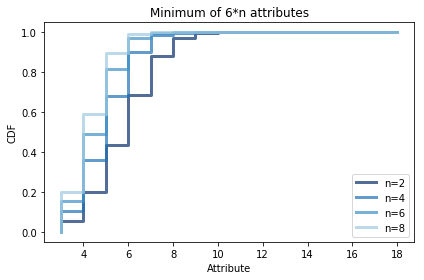

In [23]:
for n in range(2, 10, 2):
    cdf_min = compute_cdf_min(cdf_thrice, n*6)
    thinkplot.Cdf(cdf_min, label='n=%s'%n)

thinkplot.decorate(xlabel='Attribute',
                   ylabel='CDF',
                   title='Minimum of 6*n attributes')

And again we can check it by comparing to simulation results.

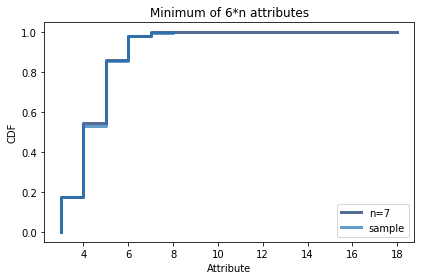

In [24]:
n = 7
cdf = compute_cdf_min(cdf_thrice, n*6)
thinkplot.Cdf(cdf, label='n=%s'%n)

sample_min = [min(cdf_thrice.Sample(42)) for i in range(1000)]
thinkplot.Cdf(thinkbayes2.Cdf(sample_min), label='sample')

thinkplot.decorate(xlabel='Attribute',
                   ylabel='CDF',
                   title='Minimum of 6*n attributes')

For efficiency and conciseness, it is helpful to precompute the distributions for the relevant values of `n`, and store them in dictionaries.

In [25]:
like_min = {}
like_max = {}

for n in range(2, 11):
    cdf_min = compute_cdf_min(cdf_thrice, n*6)
    like_min[n] = cdf_min.MakePmf()
    cdf_max = cdf_thrice.Max(n*6)
    like_max[n] = cdf_max.MakePmf()
    print(like_min[n][5], like_max[n][16])

0.23288163935889017 0.23288163935889017
0.28826338107405935 0.2882633810740594
0.31794402625472684 0.3179440262547268
0.32955796250238156 0.32955796250238156
0.32871475364520075 0.3287147536452008
0.3195146933518256 0.3195146933518255
0.3049352170780888 0.30493521707808885
0.2871203018328896 0.28712030183288956
0.2675970126720095 0.2675970126720096


The output shows that the particular data we saw is symmetric: the chance that 16 is the maximum is the same as the chance that 5 is the minimum.

Finally, we need the probability that the minimum and maximum are held by the same person.  If there are `n` players, there are `6*n` attributes.

Let's call the player with the highest attribute Max.  What is the chance that Max also has the lowest attribute?  Well Max has 5 more attributes, out of a total of `6*n-1` remaining attributes.

So here's `prob_same` as a function of `n`.

In [26]:
def prob_same(n):
    return 5 / (6*n-1)

for n in range(2, 11):
    print(n, prob_same(n))

2 0.45454545454545453
3 0.29411764705882354
4 0.21739130434782608
5 0.1724137931034483
6 0.14285714285714285
7 0.12195121951219512
8 0.10638297872340426
9 0.09433962264150944
10 0.0847457627118644


### The update

Here's a class that implements this likelihood function.

In [27]:
class Dungeons(Suite):
    
    def Likelihood(self, data, hypo):
        """Probability of the data given the hypothesis.
        
        data: lowest attribute, highest attribute, boolean
              (whether the same person has both)
        hypo: number of players
        
        returns: probability
        """
        lowest, highest, same = data
        n = hypo
        
        p = prob_same(n)
        like = p if same else 1-p
        
        like *= like_min[n][lowest]
        like *= like_max[n][highest]

        return like

Here's the prior we computed above.

7.000868145040201

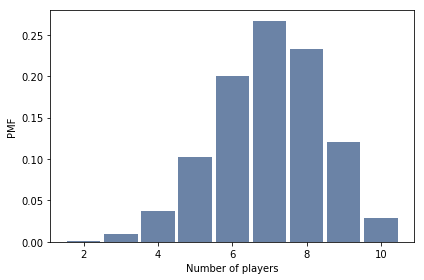

In [28]:
suite = Dungeons(prior)
thinkplot.Hist(suite)
thinkplot.decorate(xlabel='Number of players',
                   ylabel='PMF')
suite.Mean()

And here's the update based on the data in the problem statement.

In [29]:
suite.Update((5, 16, False))

0.08548474490284354

Here's the posterior.

6.940862784521086

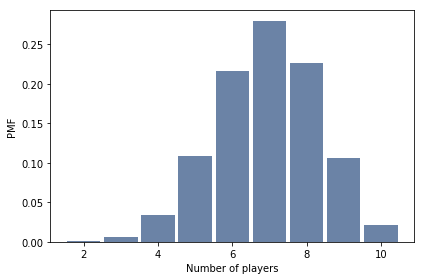

In [30]:
thinkplot.Hist(suite)
thinkplot.decorate(xlabel='Number of players',
                   ylabel='PMF')
suite.Mean()

In [31]:
suite.Print()

2 0.0005007044860801902
3 0.006177449626400222
4 0.03402191676923563
5 0.10823000113979393
6 0.21684925990462955
7 0.279837163496623
8 0.22697589141459018
9 0.10574761295351938
10 0.02166000020912791


Based on the data, I am 94% sure there are between 5 and 9 players.

In [32]:
suite.CredibleInterval()

(5, 9)

In [33]:
sum(suite[n] for n in [5,6,7,8,9])

0.9376399289091562